In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential


In [4]:
# Download stock data
start = '2012-01-01'
end = datetime.today().strftime('%Y-%m-%d')
stock = 'GOOG'

In [5]:
data = yf.download(stock, start, end)
data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


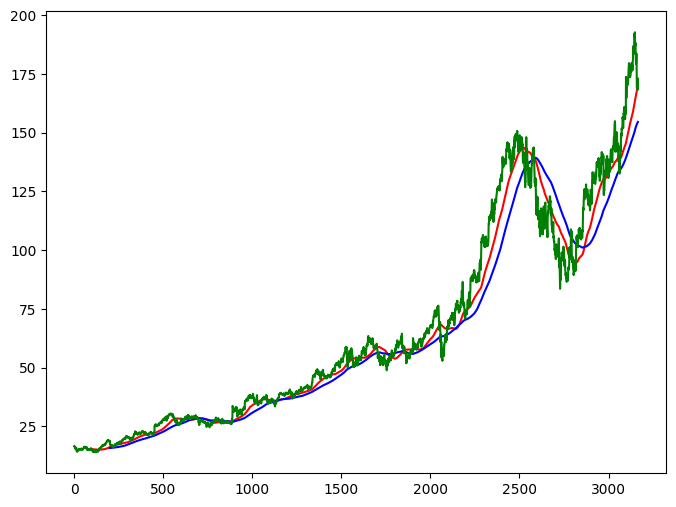

In [6]:
# Plot moving averages
ma_100_days = data.Close.rolling(100).mean()
ma_200_days = data.Close.rolling(200).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [7]:
data.dropna(inplace=True)

In [8]:
# Split data into training and testing sets
data_train = pd.DataFrame(data.Close[0:int(len(data) * 0.80)])
data_test = pd.DataFrame(data.Close[int(len(data) * 0.80):len(data)])

scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scale = scaler.fit_transform(data_train)

In [9]:
# Prepare training data for LSTM
x_train, y_train = [], []
for i in range(100, data_train_scale.shape[0]):
    x_train.append(data_train_scale[i - 100:i])
    y_train.append(data_train_scale[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - loss: 0.0526
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - loss: 0.0048
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - loss: 0.0039
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - loss: 0.0043
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 0.0047
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - loss: 0.0032
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - loss: 0.0033
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - loss: 0.0028
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - loss: 0.0029
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - loss: 0.0028
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - loss: 0.0029
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - loss: 0.0031
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 0.0028
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - loss: 0.0026
Epoch 15/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 

In [11]:
# Prepare test data
past_100_days = data_train.tail(100)
final_df = pd.concat([past_100_days, data_test], ignore_index=True)
input_data = scaler.transform(final_df)

x_test, y_test = [], []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100:i])
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

In [12]:
# Make predictions
y_predicted = model.predict(x_test)
y_predicted = scaler.inverse_transform(y_predicted)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


In [13]:
# Calculate accuracy
mae = mean_absolute_error(data_test.values, y_predicted)
mse = mean_squared_error(data_test.values, y_predicted)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 7.8531273321398425
Mean Squared Error (MSE): 96.66138042780314
Root Mean Squared Error (RMSE): 9.831651968403028


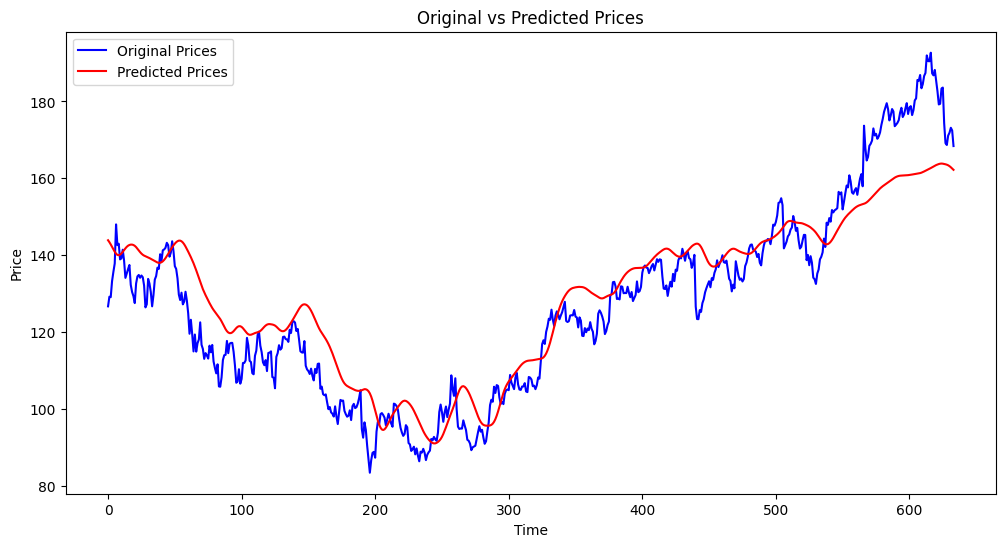

In [14]:
# Plot original vs predicted for test data
plt.figure(figsize=(12,6))
plt.plot(data_test.values, 'b', label='Original Prices')
plt.plot(y_predicted, 'r', label='Predicted Prices')
plt.title('Original vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:
# Predict next 30 days
last_100_days = input_data[-100:]
next_30_days_predictions = []
for _ in range(30):
    next_pred = model.predict(last_100_days.reshape(1, 100, 1))
    next_30_days_predictions.append(next_pred[0, 0])
    last_100_days = np.append(last_100_days[1:], next_pred[0, 0]).reshape(100, 1)

next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_30_days_predictions = next_30_days_predictions.flatten()

# Print the predicted stock prices for the next 30 days
print("Predicted stock prices for the next 30 days:")
print(next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━

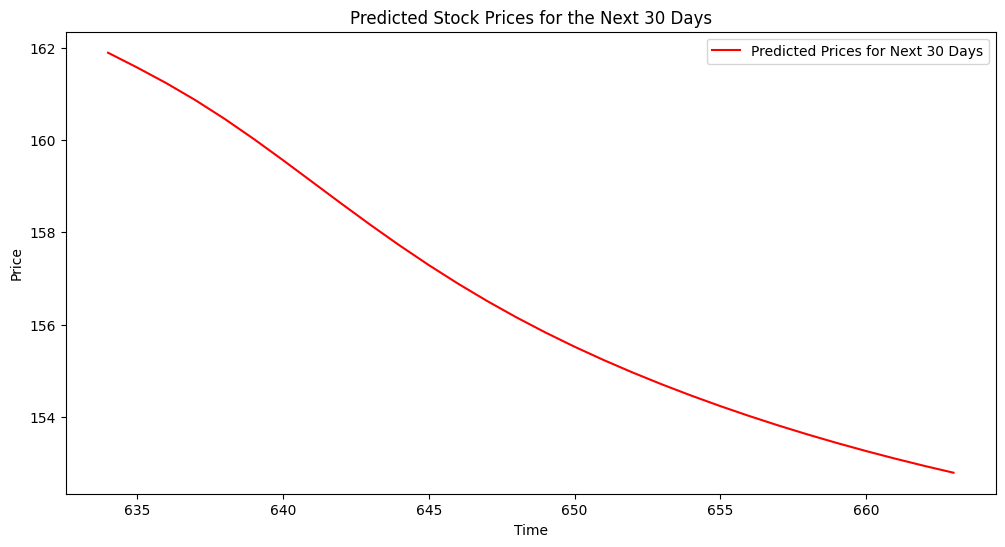

In [16]:
# Plot the next 30 days predictions
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(data_test), len(data_test) + 30), next_30_days_predictions, 'r', label='Predicted Prices for Next 30 Days')
plt.title('Predicted Stock Prices for the Next 30 Days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

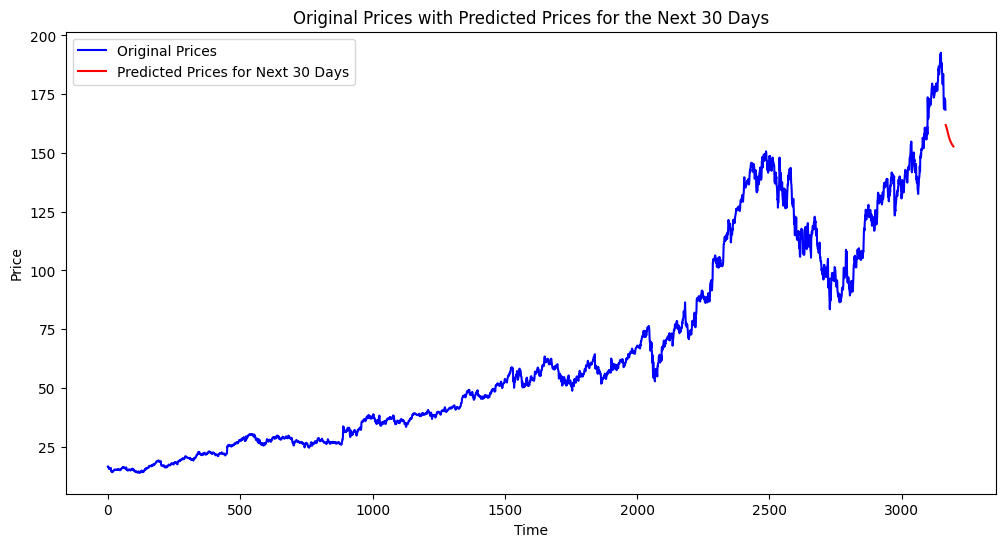

In [17]:
# Merge and plot the original data with the next 30 days predictions
plt.figure(figsize=(12,6))
plt.plot(data.Close, 'b', label='Original Prices')
plt.plot(np.arange(len(data), len(data) + 30), next_30_days_predictions, 'r', label='Predicted Prices for Next 30 Days')
plt.title('Original Prices with Predicted Prices for the Next 30 Days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [19]:
model.save('stock-pred-model.h5')